# Recurrent artificial neural networks
# Long Short-Term Memory - LSTM
--------

This notebook will guide you through the training and testing of a LSTM network in the task of predicting the speed of a runner for a given slope by using her/his previous speeds during a given race.

Before running the cells in this notebook you have to upload some files with data from some races and the Python module for parsing those files and preparing a dataset.
### left panel -> Files -> Upload
Then select the compressed folder **strava.zip** and the Python module **strava.py**

### OR
Uncomment and update the code in the following cell if your data is in your google drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp 'drive/My Drive/Colab Notebooks/strava.zip' .
#!cp 'drive/My Drive/Colab Notebooks/strava.py' .

Let us start by loading some Python modules

In [2]:
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import strava as st

2025-12-05 09:14:40.135413: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 09:14:40.135681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 09:14:40.171775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 09:14:41.203026: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Then, let us unzip the compressed file you uploaded

In [3]:
if os.path.exists('strava'):
  print('Data are already in folder')
else:
  if os.path.exists('strava.zip'):
    !unzip strava.zip
  else:
    print('You must upload the data first!')

Data are already in folder


Declare some constants

In [4]:
PATH_DATA = 'strava'

FEATURES = ['time', 'speed', 'slope']    # selected from ['time', 'elevation', 'distance', 'speed', 'slope']
SPEED_OUTLIER = 8.0                      # speed > 30km/h
SLOPE_OUTLIER = 80                       # slope > +-80%
TIME_PERIOD = 1*60                       # period of time to average
SEGMENT_LENGTH = 100                     # length of the segment to average data
AVERAGE_SPEED_TH = 2.4                   # threshold to further clean the dataset

### Read the data
Parse the files in the **strava** folder

In [5]:
importer = st.RunImport(SPEED_OUTLIER, SLOPE_OUTLIER, TIME_PERIOD, SEGMENT_LENGTH, AVERAGE_SPEED_TH)
dataset = importer.import_path(PATH_DATA)

processing 20120826-100039-Run.tab
processing 20130925-191237-Run.tab
processing 20140507-193537-Run.tab
processing 20111122-172943-Run.tab
processing 20111115-172413-Run.tab
processing 20151115-102833-Run.tab
processing 20130928-060506-Run.tab
processing 20150317-135613-Run.tab
processing 20160220-154836-Run.tab
processing 20120915-145133-Run.tab
processing 20121111-145838-Run.tab
processing 20130525-124847-Run.tab
processing 20151101-111401-Run.tab
processing 20111130-172424-Run.tab
processing 20150122-133931-Run.tab
processing 20130224-171336-Run.tab
processing 20111108-164522-Run.tab
processing 20120508-154642-Run.tab
processing 20121016-143224-Run.tab
processing 20130919-061037-Run.tab
processing 20141210-200550-Run.tab
processing 20140607-090004-Run.tab
processing 20131109-065908-Run.tab
processing 20140201-105937-Run.tab
processing 20160131-145858-Run.tab
processing 20130413-131504-Run.tab
processing 20130721-160724-Run.tab

Race 25 ignored. Average speed: 2.2096998335060936
pro

,time,elevation,distance,speed,slope,race
count,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000
mean,1854.441504,771.486180,5455.456205,3.043774,0.000594,117.825866
std,1433.385657,179.491611,4154.601351,0.398492,5.166486,66.100288
min,0.000000,6.170000,0.000000,0.000000,-23.195081,0.000000
25%,781.000000,755.680000,2292.405653,2.813920,-3.156888,61.000000
50%,1548.000000,798.381667,4587.222821,3.065299,-0.011887,119.000000
75%,2551.000000,830.025893,7594.768761,3.295895,3.117112,175.000000
max,7610.000000,2563.000000,21267.295568,7.864821,27.562581,229.000000



Dataset sample:


,time,elevation,distance,speed,slope,race
0,30,747.190909,89.001500,2.668016,4.054548,0
1,64,748.987500,196.342511,3.152147,2.869657,0
2,100,752.127273,294.125425,2.624402,3.315943,0
3,128,755.928571,383.062608,3.183812,3.373567,0
4,169,757.158333,496.611718,2.733093,1.390015,0
20663,3560,863.560000,11394.966932,3.479775,3.649175,229
20664,3584,865.550000,11480.029247,3.544263,0.548916,229
20665,3615,861.140000,11590.756189,3.581753,-4.661148,229
20666,3639,860.775000,11677.779602,3.625976,0.123151,229
20667,3670,858.016667,11793.636647,3.722071,-2.984481,229


### Example of a race
The following cell shows an example of the data from a race

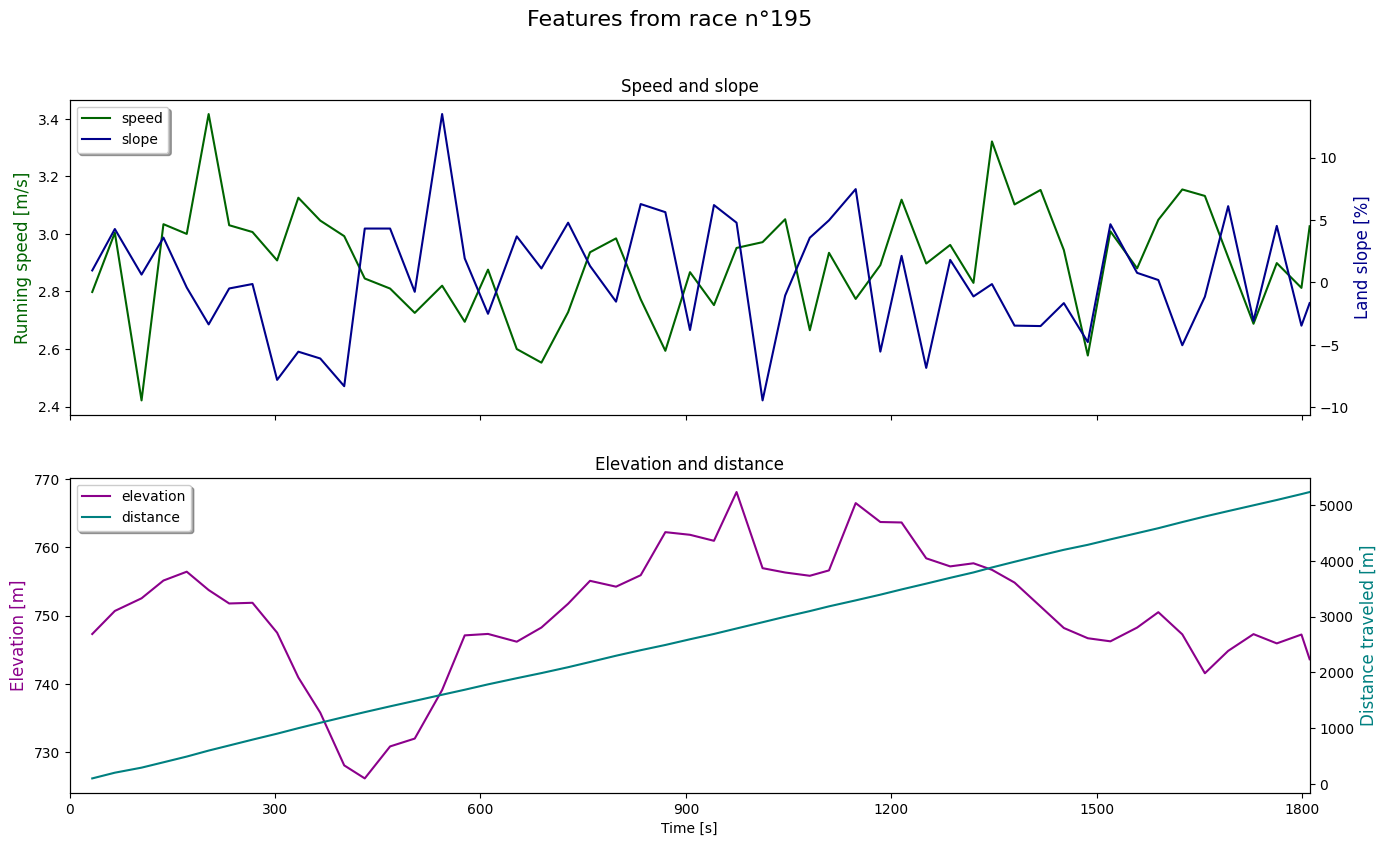

In [6]:
st.plot_race(dataset, np.random.randint(dataset['race'].max()))

### Normalize the dataset
The following cell normalizes the features into the interval [0, 1]

In [7]:
# Copy the dataset before normalisation, feature selection, numpy conversion, etc.
original_dataset = dataset.copy(deep=True)
min_speed = original_dataset['speed'].min()
max_speed = original_dataset['speed'].max()

#normalize only the selected features
#transform to numpy
normalized_dataset = dataset.filter(items=FEATURES).values
scaler = MinMaxScaler()
scaler.fit(normalized_dataset)
normalized_dataset = scaler.transform(normalized_dataset)
#transform back to dataframe
normalized_dataset = pd.DataFrame(normalized_dataset, index=dataset.index, columns=FEATURES)

#update the dataset with the new values
dataset.update(normalized_dataset)

print("Min (per features):", scaler.data_min_)
print("Max (per features):", scaler.data_max_)
display(dataset.head())

Min (per features): [  0.           0.         -23.19508109]
Max (per features): [7610.            7.86482054   27.56258073]


/tmp/ipykernel_1715652/765495803.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00394218 0.00840999 0.0131406  ... 0.47503285 0.4781866  0.48226018]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.update(normalized_dataset)


,time,elevation,distance,speed,slope,race
0,0.003942,747.190909,89.001500,0.339234,0.536857,0
1,0.008410,748.987500,196.342511,0.400791,0.513513,0
2,0.013141,752.127273,294.125425,0.333689,0.522306,0
3,0.016820,755.928571,383.062608,0.404817,0.523441,0
4,0.022208,757.158333,496.611718,0.347509,0.484362,0


### Create a training and a testing subset
Split the dataset into training and testing


In [8]:
TIMESTEPS = 20                   #define sequence length
TEST_SIZE = 0.2                  #value between ]0;1[
TRAINING_SIZE = 1 - TEST_SIZE

In [9]:
all_races = np.unique(dataset['race'])
print('Number of races', len(all_races))
RACES_TRAINING = int(np.floor(TRAINING_SIZE * len(all_races)))
races_train = np.random.choice(all_races, RACES_TRAINING, replace=False)
# print(races_train)
races_test = list(set(all_races) - set(races_train))
# print(races_test)
print(len(races_train), 'used during training --- Number of samples', np.sum(np.isin(dataset['race'], races_train)))
print(len(races_test), 'used during test\t --- Number of samples', np.sum(np.isin(dataset['race'], races_test)))

Number of races 230
184 used during training --- Number of samples 16769
46 used during test	 --- Number of samples 3899


### Create inputs and outputs
The folowing cell contains the function that will be used to create the inputs and outputs for training the models

In [10]:
#take a dataframe as input and return the splitted version with the prediction as a numpy array
def create_x_y(data, races):
  speed_index = data[FEATURES].columns.get_loc('speed') #get speed index
  slope_index = data[FEATURES].columns.get_loc('slope') #get slope index
  time_index = data[FEATURES].columns.get_loc('time') #get time index
  x = None
  y = None

  #iterate over every race
  for r in races:
    #filter race
    race_df = data.loc[data['race'] == r]
    #filter features
    race_np = race_df[FEATURES].values
    #split into timesteps (timesteps + 1 to take the target value)
    race_np = [race_np[i:(i+TIMESTEPS+1)] for i in range(race_np.shape[0] - (TIMESTEPS+2))]

    if len(race_np) == 0:
      print("Warning: not enough values in race", r)
      continue

    race_np = np.stack(race_np, axis=0)

    temp_x = np.dstack([race_np[:,1:,time_index],       # last TIMESTEPS-1 times and next time
                       race_np[:,1:,slope_index],       # last TIMESTEPS-1 slopes and next slope
                       race_np[:,:-1,speed_index]])     # last TIMESTEPS speeds
    temp_y = race_np[:,-1, speed_index]                 # next speed

    if x is None:
      x = temp_x
      y = temp_y
    else:
      x = np.append(x, temp_x, axis=0)
      y = np.append(y, temp_y, axis=0)

  return x, y

In [11]:
print('original shape:', dataset.shape)

X_train, y_train = create_x_y(dataset, races_train)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_test, y_test = create_x_y(dataset, races_test)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


original shape: (20668, 6)
X_train shape: (12721, 20, 3)
y_train shape: (12721,)
X_test shape: (2887, 20, 3)
y_test shape: (2887,)


### Create a model and train it
The following cells create a LSTM network and train it with the training subset

In [12]:
BATCH_SIZE = 64          # Size of the batch for training
NB_EPOCHS = 30    # Number of times the training dataset is presented
NB_UNITS = 1         # Number of LSTM units

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(NB_UNITS, input_shape=(TIMESTEPS, len(FEATURES))))
#dense layer 1 : connect all LSTM cell to one cell -> output shape as (*, 1)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2025-12-05 09:14:59.971179: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/rafou/.pyenv/versions/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_test, y_test))

Epoch 1/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1398 - val_loss: 0.0628
Epoch 2/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0313 - val_loss: 0.0139
Epoch 3/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 4/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 6/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 11/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 12/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

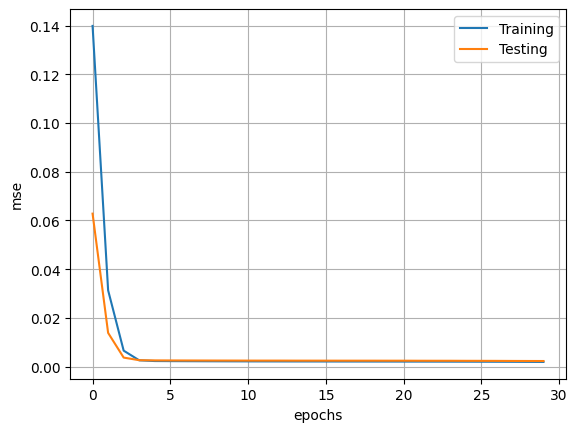

In [14]:
# Plot the training and testing
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.xlabel('epochs')
pl.ylabel('mse')
pl.legend()
pl.grid()

### Evaluate the performance of the model
The following cell computes the correlation between the actual speed of the runner and the model's output

In [15]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training correlation coefficient:', np.corrcoef(y_train.T, y_train_pred.T)[0,1])
print('Test correlation coefficient:', np.corrcoef(y_test.T, y_test_pred.T)[0,1])

398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training correlation coefficient: 0.36755059120032424
Test correlation coefficient: 0.33095970305533107


### Visualize the results
The following cell visualize the output of the LSTM for a single race in the testing subset and compare it with the actual speed of the runner

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


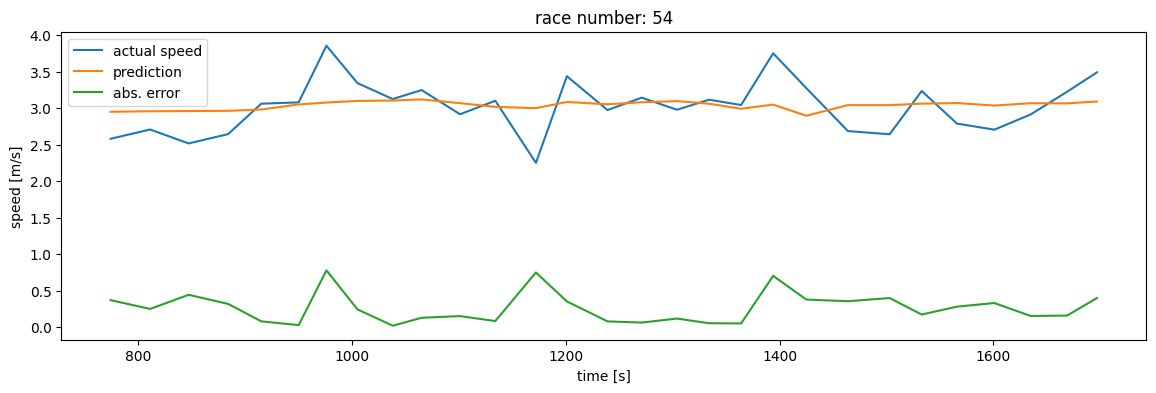

In [16]:
random_race = np.random.choice(races_test)
X, y = create_x_y(dataset, [random_race])
X_o, y_o = create_x_y(original_dataset, [random_race])            # select inputs and output from the unnormalized dataset also

y_pred_o = model.predict(X) * (max_speed - min_speed) + min_speed # unnormalize the prediction

pl.figure(figsize=(14,4))
pl.plot(X_o[:,-1,0], y_o, label='actual speed')
pl.plot(X_o[:,-1,0], y_pred_o, label='prediction')
pl.plot(X_o[:,-1,0], np.abs(y_o - y_pred_o[:,0]), label='abs. error')
pl.legend()
pl.title('race number: ' + str(random_race))
pl.xlabel('time [s]')
pl.ylabel('speed [m/s]');


# Exercise

1. Change the number of units and epochs of the LSTM network. Show the configuration that performed the best.
2. What is the largest error (speed prediction) you observed? Do you observe that most of those large errors show up for high speeds ? or low speeds? Why?
3. Using the predicted speeds for a given race, compute the expected time for a race and compute the difference between the real race time and the predicted race time in minutes. Provide the code of the cell that computes this prediction error.

We wortk with a time series of speed measurments recorded during a race. <br>
Each pair of consecutive observations define a segments and it's duration is given by timestamp difference delta_T  <br>
To compute the real distance, we multiply the speed at each observation by the delta_T: distance = speed * delta_T <br>
The total time of the race is given by the sum of the times of each segment: total_time = sum(distance / speed) <br>
To compute the error we compute the difference between the predicted total time and the original total time over 60 to get the error in minutes.<br>



In [ ]:
# delta t between each point (from real timestamps)
delta_t = np.diff(X_o[:, -1, 0])

# We retrieve the actual and predicted speeds aligned with segment times
# since delta_t has length N-1, we take the first N-1 speeds
actual_speed = y_o[:-1]
predicted_speed = y_pred_o[:-1, 0]

# the distance travelled in each segment
distance = actual_speed * delta_t

# real time = sum of distance / actual speed and the division by 60 to have minutes
real_time_min = np.sum(distance / actual_speed) / 60

# the same distance but with predicted speed and division by 60 to have minutes
pred_time_min = np.sum(distance / predicted_speed[:]) / 60

print(f"Actual time: {real_time_min:.2f} min")
print(f"Predicted time: {pred_time_min:.2f} min")
print(f"Prediction error: {real_time_min - pred_time_min:.2f} min")
print(f"Percentage error: {100 * abs(real_time_min - pred_time_min) / real_time_min:.2f} %")

Actual time: 15.38 min
Predicted time: 15.23 min
Prediction error: 0.15 min
Percentage error: 0.98 %
